# Heat Transfer (L3)
**Mattia Sotgia<sup>1</sup>, Francesco Polleri <sup>1</sup>** \
_<sup>1</sup>Dipartimento di Fisica, Università degli studi di Genova_


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

from utils import Analysis, AnalysisData
from utils import Data

from uncertainties import ufloat

import ROOT
from iminuit import Minuit
from iminuit.cost import LeastSquares
import mplhep as hep

from scipy import fft

plt.style.use(['std-colors',hep.style.ATLAS])

Welcome to JupyROOT 6.24/02


## Analisi dati
Abbiamo acquisito 1200 punti (con frequenza di 10Hz) divisi in 4 dataset, divsi come
 - 2 dataaset (`20230321_1_1s` e `20230321_2_1s`) con impulso iniziale di ~1 s
 - 1 dataset con $\Delta_\text{pulse}$ = 0.5 e 1 dataset con 1.5 s

La `dataclass` Data contiene i dati necessari e anche una visualizzazione rapida, accessibile come `Data.prelim_plot()`, anche potendo esplorare limiti bassi e alti nei tempi. 

Importo i dati in un formato comodo per la trasformzione successiva. 

In [2]:
D1 = Data(np.loadtxt('data/20230321_1_1s.lvm', skiprows=23, unpack=True), 1, 1)
D2 = Data(np.loadtxt('data/20230321_2_1s.lvm', skiprows=23, unpack=True), 1, 2)
D3 = Data(np.loadtxt('data/20230321_3_1s.lvm', skiprows=23, unpack=True), 1, 3)
D4 = Data(np.loadtxt('data/20230321_4_0.5s.lvm', skiprows=23, unpack=True), 0.5, 4)
D5 = Data(np.loadtxt('data/20230321_5_1.5s.lvm', skiprows=23, unpack=True), 1.5, 5)

datasets = [D1, D2, D3, D4, D5]

Possiamo così rapidamente analizzare i valori ottenuti (per esempio osservo subito che la temperatura del PT100 risulta invariante rispetto al tempo)

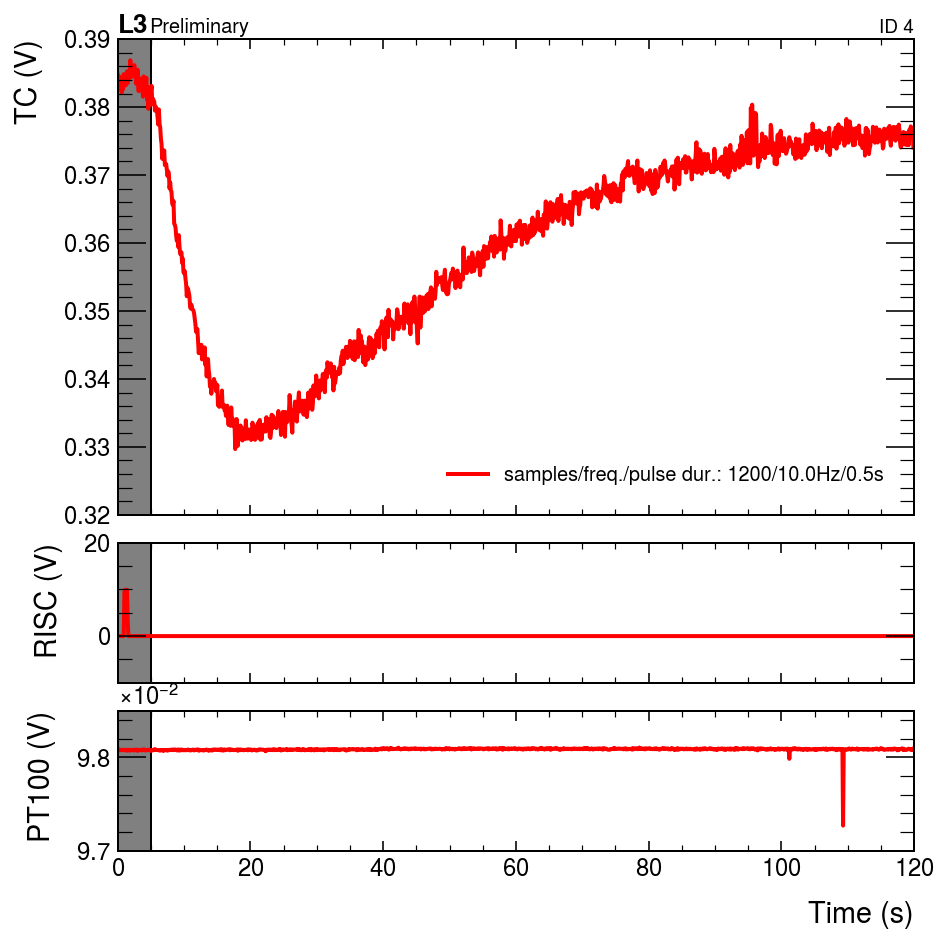

In [3]:
D4.prelim_plot(0,5)

Data l'equazione per una sbarretta semi-infinita (correggo poi dopo con una restrizione del dominio), $$\frac{\partial T}{\partial t} = k \nabla T,$$ possiamo ottenere soluzione del tipo $$T(x,t) = \frac{C}{\sqrt{Dt}} \exp(-\frac{x^2}{4Dt}) + T_0.$$

### Linearizzazione

Posso osservare che graficando idealmente $$\log{\sqrt{t}T_\text{TC}} = \log\left(\frac{C}{\sqrt{D}} \exp(-\frac{x^2}{4Dt})\right)$$ contro $1/t$, allora diventa $f(1/t) = -\frac{x_0^2}{4Dt}$, che risulta essere più comoda da trattare

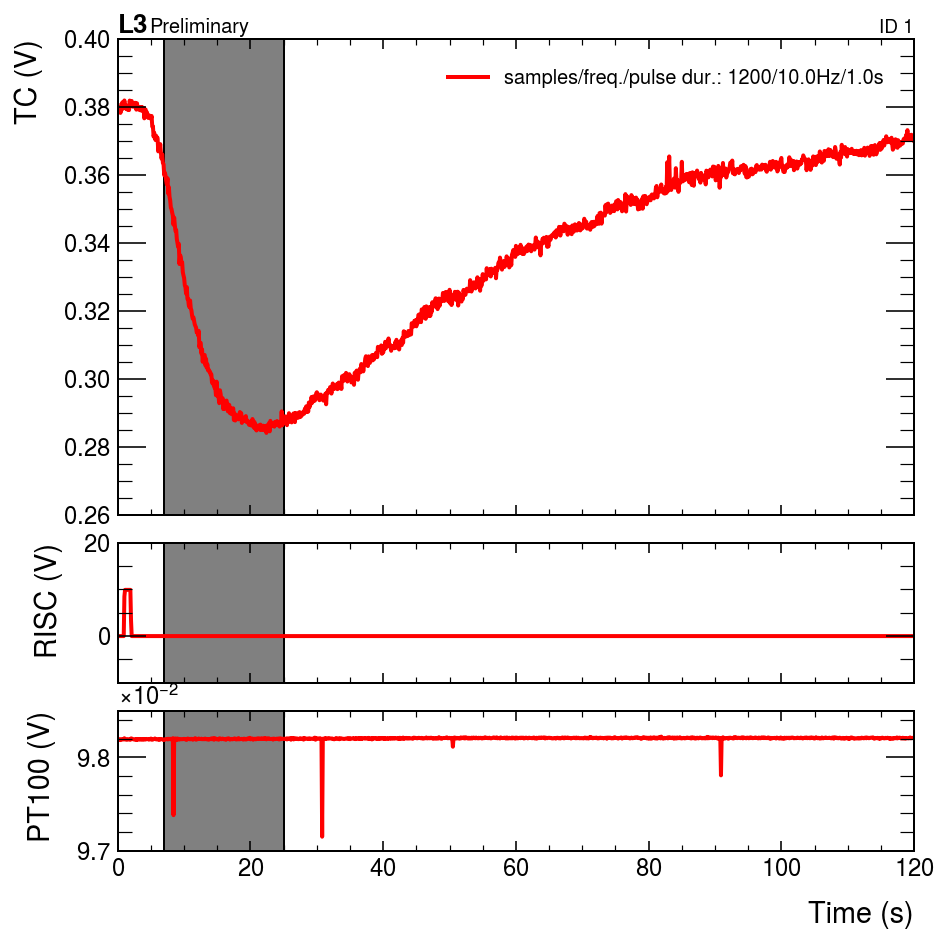

In [4]:
low, up = 7, 25
D1.prelim_plot(low,up)

┌─────────────────────────────────────────────────────────────────────────    
│ D = 6.020(24)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D1)    
│ (p-value: 0.0, χ2/df = (1817.8476961834785, 178.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 6.137(28)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D2)    
│ (p-value: 0.0, χ2/df = (1798.307217493346, 178.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 5.722(34)e-06 m^2/s 	for samples/freq./pulse dur.: 240/2.0Hz/1.0s (D3)    
│ (p-value: 0.0, χ2/df = (1053.1372633886742, 34.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 6.15(5)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/0.5s (D4)    
│ (p-value: 0.0, χ2/df = (587.720727364311, 178.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 5.789(18)e-06 m^2/s 	for samples/freq./pulse dur.: 1200

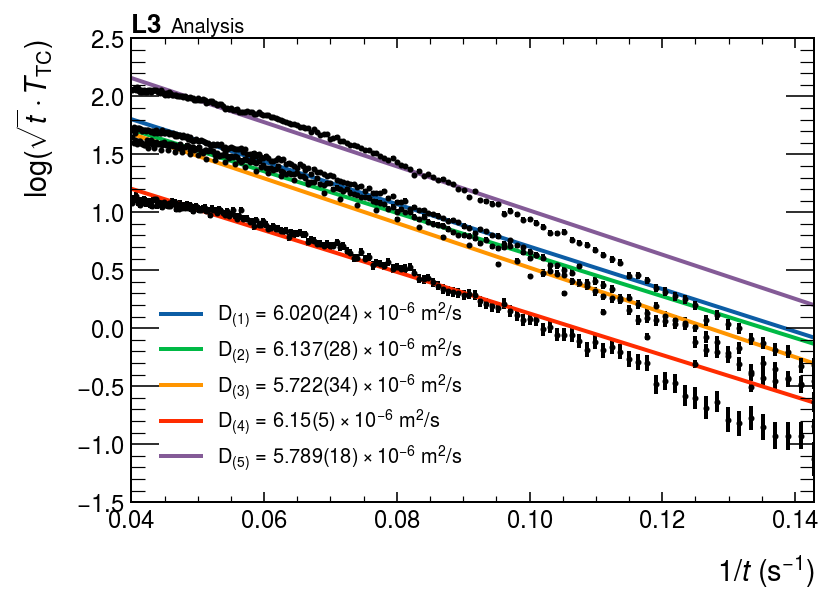

In [5]:
for i, D in enumerate(datasets):
    value, error, M = Analysis(D).filter(low, up).linearized_model_fit(-30, 2)

plt.xlim(1/up, 1/low) # adjust th xlim (broken?)
hep.label.exp_text('L3 ', 'Analysis')
plt.legend()
plt.savefig('lplot_1-5.pdf', bbox_inches='tight')

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.38(8)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D1)    
│ (p-value: 0.2767813362014787, χ2/df = (177.37079810061437, 167.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.85(8)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/1.0s (D2)    
│ (p-value: 4.298003529956684e-05, χ2/df = (248.56490698562274, 167.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.70(11)e-06 m^2/s 	for samples/freq./pulse dur.: 240/2.0Hz/1.0s (D3)    
│ (p-value: 0.01701896911656875, χ2/df = (47.38212778982111, 29.0))

┌─────────────────────────────────────────────────────────────────────────    
│ D = 9.76(15)e-06 m^2/s 	for samples/freq./pulse dur.: 1200/10.0Hz/0.5s (D4)    
│ (p-value: 0.9722753364820487, χ2/df = (133.81214947771915, 167.0))

┌─────────────────────────────────────────────────────────────────────────    

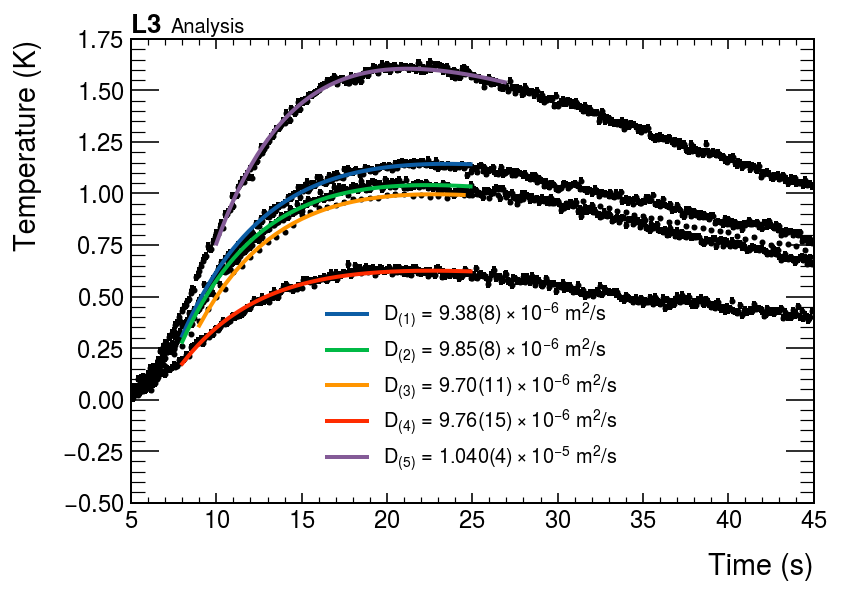

In [6]:
fit_limits = [
    (8,25), #> D1
    (8,25), #> D2
    (9,25), #> D3
    (8,25), #> D4
    (10,27), #> D5
]

for i, D in enumerate(datasets):
    value, error, M = Analysis(D).filter(5, 45).full_model_fit(fit_limits=fit_limits[i])

plt.ylim(-0.5, 1.75)
hep.label.exp_text('L3 ', 'Analysis')
plt.legend()
plt.savefig('fplot_1-5.pdf', bbox_inches='tight')

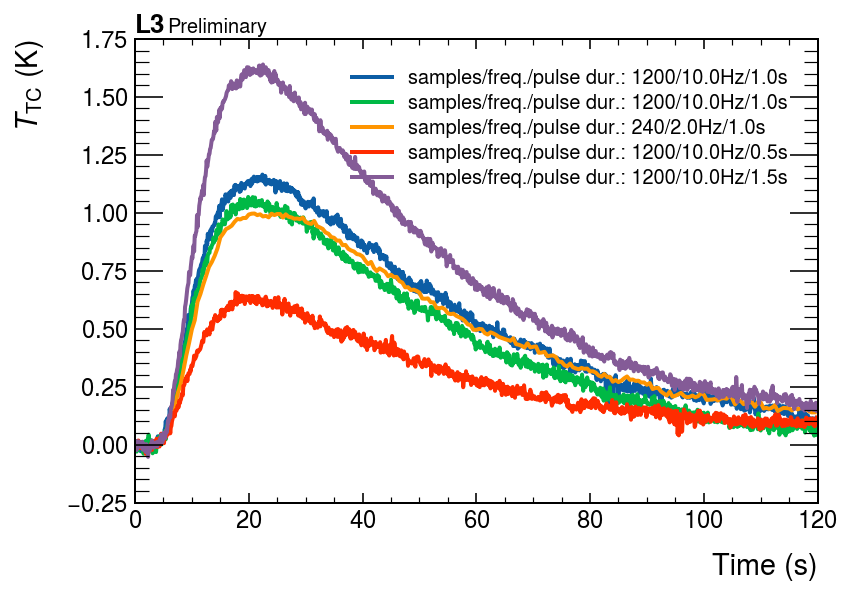

In [7]:
for i, D in enumerate(datasets):
    plt.plot(D.time[1:], Analysis(D).data.T_TC[1:], label=D.name)
plt.xlabel('Time (s)')
plt.ylabel('$T_\mathrm{TC}$ (K)')
hep.label.exp_text('L3','Preliminary')
_ = plt.legend()